<a href="https://colab.research.google.com/github/monindew/study/blob/main/%E1%84%8B%E1%85%B4%E1%84%85%E1%85%AD%E1%84%8B%E1%85%B5%E1%86%AB%E1%84%80%E1%85%A9%E1%86%BC%E1%84%8C%E1%85%B5%E1%84%82%E1%85%B3%E1%86%BC%E1%84%92%E1%85%A1%E1%86%A8%E1%84%92%E1%85%AC%E1%84%80%E1%85%A1%E1%86%BC%E1%84%8B%E1%85%B4_%EA%B0%9C%EB%B0%9C%EC%9E%90%EB%A5%BC%EC%9C%84%ED%95%9CAI%EC%8B%A4%EC%8A%B5%EA%B5%90%EC%9C%A1_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 의료인공지능학회_CNN

# 개발자를 위한 AI 실습교육
# 2024. 10. 24

In [1]:
import torch  # PyTorch 라이브러리 임포트
import torch.nn as nn  # 신경망 모듈(nn)을 임포트
import torch.optim as optim  # 최적화 모듈(optim)을 임포트
import torch.backends.cudnn as cudnn  # GPU 성능 최적화를 위한 cudnn 백엔드 임포트
import numpy as np  # 배열 및 수학 계산을 위한 NumPy 임포트
import torchvision  # 이미지 데이터셋 및 모델을 위한 torchvision 임포트
from torchvision import datasets, models, transforms  # 데이터셋, 모델, 이미지 변환(transform) 임포트
import matplotlib.pyplot as plt  # 그래프 시각화를 위한 matplotlib의 pyplot 임포트
import time  # 시간 측정을 위한 time 모듈 임포트
import PIL  # 이미지 처리를 위한 Python Imaging Library (PIL) 임포트
import os  # 파일 및 디렉토리 작업을 위한 os 모듈 임포트
from PIL import Image  # 이미지 파일 처리를 위한 Image 클래스 임포트
from tempfile import TemporaryDirectory  # 임시 디렉토리 생성 모듈 임포트

In [2]:
!pip install split-folders  # split-folders 라이브러리 설치 (데이터셋 분할용)
import splitfolders  # 데이터셋 분할을 위한 splitfolders 라이브러리 임포트

!gdown 1F-2UVD7_a2q13Gv5ns_F2Ytc2N0V8pos  # Google Drive에서 데이터셋 다운로드
!tar -zxf MedNIST.tar.gz  # 다운로드한 압축 파일을 풀기

cudnn.benchmark = True  # GPU 성능 최적화를 위해 cudnn 벤치마크 모드 활성화

Downloading...
From (original): https://drive.google.com/uc?id=1F-2UVD7_a2q13Gv5ns_F2Ytc2N0V8pos
From (redirected): https://drive.google.com/uc?id=1F-2UVD7_a2q13Gv5ns_F2Ytc2N0V8pos&confirm=t&uuid=05abce38-2b19-4ce6-828b-f65a8769271c
To: /content/MedNIST.tar.gz
100% 61.8M/61.8M [00:01<00:00, 31.9MB/s]


In [3]:
root_dir = os.path.join("MedNIST") # mednist 데이터셋이 있는 경로

In [4]:
class_names = sorted(x for x in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, x)))  #  클래스 이름 리스트
num_class = len(class_names) # 클래스 개수
image_files = [ # 각 클래스별 이미지 경로 리스트
    [os.path.join(root_dir, class_names[i], x) for x in os.listdir(os.path.join(root_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)] # 각 클래스별 이미지 개수
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i]) # 이미지 경로 리스트
    image_class.extend([i] * num_each[i]) # 이미지 라벨 리스트
num_total = len(image_class)   # 전체 이미지 개수
image_width, image_height = PIL.Image.open(image_files_list[0]).size # 이미지 사이즈 확인

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


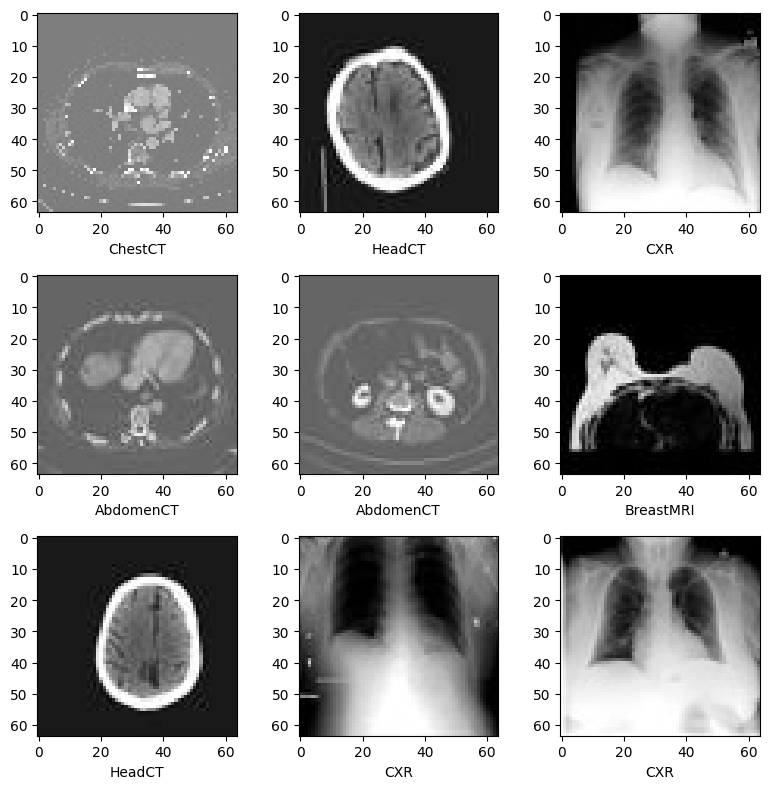

In [5]:
# 예시 이미지 출력
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [6]:
data_dir="data"
# train, val, test 데이터로 분할
splitfolders.fixed(root_dir, data_dir,
    seed=1337, fixed=(1000,100,100),group_prefix=None) # 각 클래스별 1000개씩 train, 100개씩 val, 100개씩 test 데이터로 분할

Copying files: 7200 files [00:01, 4347.41 files/s]


In [7]:
print(os.listdir(os.path.join(data_dir,"train"))) # train 데이터 확인

['CXR', 'BreastMRI', 'HeadCT', 'AbdomenCT', 'Hand', 'ChestCT']


In [8]:
print(os.listdir(os.path.join(data_dir,"test"))) # test 데이터 확인

['CXR', 'BreastMRI', 'HeadCT', 'AbdomenCT', 'Hand', 'ChestCT']


In [9]:
print(os.listdir(os.path.join(data_dir,"val"))) # val 데이터 확인

['CXR', 'BreastMRI', 'HeadCT', 'AbdomenCT', 'Hand', 'ChestCT']


In [10]:
# Data augmentation and normalization for training
# Just normalization for validation

# 데이터셋에 적용할 변형(transformation) 정의
data_transforms = {
    'train': transforms.Compose([ # 데이터 변환 설정
        transforms.ToTensor(),  # 이미지를 텐서 형식으로 변환
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Normalize란? 안정적인 학습을 위해 표준화; weight변화량에 덜 민감하게되며 최적화시키기 쉬워짐 ; 평균과 표준편차값을 미리 구해둠
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터셋 만들기
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
# 데이터로더 만들기
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=300,
                                             shuffle=True, num_workers=4) # 날것의 데이터셋을 학습할 때 쓰기 용이한 형태로 바꿔주는 역할
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']} # 데이터셋 크기
class_names = image_datasets['train'].classes # 클래스 이름

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용 가능 여부에 따라 device 정보 저장

In [11]:
dataset_sizes # 데이터셋 크기 확인

{'train': 6000, 'val': 600, 'test': 600}

# ResNet 모델 구조

In [12]:
# ResNet은 잔차 블록(residual block)을 사용하여 네트워크가 더 깊어지더라도 학습이 잘 되도록 만듭니다.
# 이 residual block은 Skip Connection을 통해 입력과 출력의 차이를 줄이고, 기울기 소실 문제를 해결합니다.

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        초기화 메서드: BasicBlock 객체가 생성될 때 호출됩니다.
        여러 Layer(계층)을 정의하고, 스킵 연결(Skip Connection)이 필요한지 확인합니다.
        """
        super(BasicBlock, self).__init__()  # 부모 클래스(nn.Module)의 초기화 함수 호출

        # 첫 번째 3x3 컨볼루션 계층: 입력 이미지에서 특성(feature)을 추출합니다.
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        # 배치 정규화(Batch Normalization): 각 배치에서 정규화를 수행해 학습의 안정성을 높입니다.
        self.bn1 = nn.BatchNorm2d(out_channels)

        # ReLU 활성화 함수: 비선형성을 추가해 모델이 복잡한 패턴을 학습할 수 있도록 합니다.
        # inplace=True는 메모리를 절약하기 위해 활성화 함수의 출력을 기존 메모리 공간에 덮어씁니다.
        self.relu = nn.ReLU(inplace=True)

        # 두 번째 3x3 컨볼루션 계층: 추가적인 특성 추출을 수행합니다.
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        # 두 번째 배치 정규화 계층
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 스킵 연결(Skip Connection)을 정의합니다.
        # 스킵 연결은 입력이 그대로 출력으로 전달될 수 있게 해줍니다.
        # 이는 네트워크가 매우 깊어질 때 기울기 소실 문제를 해결하는 핵심 요소입니다.
        self.skip = nn.Sequential()  # 기본적으로 아무것도 하지 않는 빈 Sequential 객체

        # 스킵 연결이 필요한 경우(입력과 출력의 채널 수나 스트라이드가 다를 때)
        if stride != 1 or in_channels != out_channels:
            # 1x1 컨볼루션 계층: 입력의 차원을 출력에 맞춰 조정합니다.
            # 스트라이드 조정이 필요한 경우도 처리할 수 있습니다.
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)  # 정규화 수행
            )

    def forward(self, x):
        """
        순전파(forward) 함수: 입력을 받아 네트워크를 거쳐 최종 출력을 반환합니다.
        스킵 연결을 사용해 입력을 더합니다.
        """
        # 스킵 연결을 통해 입력을 변환해 identity에 저장합니다.
        # (스킵 연결이 필요하지 않으면 그냥 입력이 사용됩니다.)
        identity = self.skip(x)

        # 첫 번째 컨볼루션, 배치 정규화, ReLU를 차례대로 적용합니다.
        out = self.conv1(x)  # 첫 번째 컨볼루션 수행
        out = self.bn1(out)  # 배치 정규화 수행
        out = self.relu(out)  # ReLU 활성화 적용

        # 두 번째 컨볼루션과 배치 정규화를 수행합니다.
        out = self.conv2(out)  # 두 번째 컨볼루션 수행
        out = self.bn2(out)  # 배치 정규화 수행

        # 입력(identity)을 더해줍니다(스킵 연결).
        out += identity  # 스킵 연결을 통해 입력과 출력을 더하기

        # 다시 ReLU 활성화 함수 적용 (더해진 결과에 대해)
        out = self.relu(out)

        # 최종 출력을 반환합니다.
        return out

In [13]:
# 이제 여러 BasicBlock을 사용하여 ResNet-18 모델을 만듭니다.
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        """
        ResNet 초기화 메서드입니다.
        필요한 레이어(계층)를 정의하고, 학습할 클래스의 수(num_classes)를 설정합니다.
        """
        super(ResNet, self).__init__()  # 부모 클래스(nn.Module) 초기화

        # 첫 번째 컨볼루션 계층: 입력 이미지는 3채널(RGB), 출력은 64채널입니다.
        # 3x3 커널, stride=1로 기본적인 특성 추출을 수행합니다.
        self.in_channels = 64  # 처음 입력 채널을 64로 초기화합니다.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # 배치 정규화: 초기 컨볼루션 출력(64 채널)을 정규화합니다.
        self.bn1 = nn.BatchNorm2d(64)

        # ReLU 활성화 함수: 첫 번째 컨볼루션 결과에 비선형성을 추가합니다.
        self.relu = nn.ReLU(inplace=True)

        # Residual 블록을 사용하는 네 개의 레이어를 정의합니다.
        # 각 레이어는 여러 BasicBlock으로 구성됩니다.
        self.layer1 = self._make_layer(64, 2, stride=1)   # 레이어 1: 채널 64, 블록 2개
        self.layer2 = self._make_layer(128, 2, stride=2)  # 레이어 2: 채널 128, 블록 2개
        self.layer3 = self._make_layer(256, 2, stride=2)  # 레이어 3: 채널 256, 블록 2개
        self.layer4 = self._make_layer(512, 2, stride=2)  # 레이어 4: 채널 512, 블록 2개

        # AdaptiveAvgPool2d: 입력 크기와 상관없이 1x1 크기로 평균 풀링합니다.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # 마지막 완전 연결 계층: 512차원의 입력을 클래스 개수만큼의 출력으로 변환합니다.
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        """
        여러 BasicBlock을 사용해 레이어를 만드는 헬퍼 함수입니다.
        각 레이어는 여러 블록으로 구성됩니다.
        """
        layers = []  # 블록을 담을 리스트를 초기화합니다.

        # 첫 번째 블록은 in_channels와 out_channels가 다를 수 있으므로 stride를 지정합니다.
        layers.append(BasicBlock(self.in_channels, out_channels, stride))

        # 입력 채널 수를 다음 블록을 위해 업데이트합니다.
        self.in_channels = out_channels

        # 두 번째 이후 블록은 stride=1로 입력과 출력의 크기를 동일하게 유지합니다.
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        # Sequential 객체로 변환해 반환합니다. (여러 블록을 차례로 적용)
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        순전파(forward) 메서드: 입력을 받아 정의된 네트워크를 통해 출력합니다.
        """
        # 입력 이미지에 첫 번째 컨볼루션, 배치 정규화, ReLU를 차례로 적용합니다.
        x = self.conv1(x)  # 첫 번째 컨볼루션
        x = self.bn1(x)  # 배치 정규화
        x = self.relu(x)  # ReLU 활성화

        # 네 개의 레이어를 차례로 거칩니다.
        x = self.layer1(x)  # 첫 번째 레이어
        x = self.layer2(x)  # 두 번째 레이어
        x = self.layer3(x)  # 세 번째 레이어
        x = self.layer4(x)  # 네 번째 레이어

        # AdaptiveAvgPool2d를 사용해 1x1 크기로 줄입니다.
        x = self.avgpool(x)

        # 텐서를 평탄화(flatten)하여 2차원으로 변환합니다.
        x = torch.flatten(x, 1)

        # 완전 연결 계층을 사용해 최종 출력(클래스 확률)을 계산합니다.
        x = self.fc(x)

        return x  # 최종 출력 반환

In [19]:
# 이제 모델의 아키텍처를 정의했으므로, 모델을 학습시켜야 합니다.
# 여기서는 손실 함수(교차 엔트로피)와 옵티마이저(확률적 경사 하강법)를 지정합니다.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU가 사용 가능하면 GPU를 사용하고, 그렇지 않으면 CPU 사용
model = ResNet(num_classes=num_class).to(device)  # ResNet 모델을 설정하고 장치로 이동
loss_function = nn.CrossEntropyLoss()  # 교차 엔트로피 손실 함수 정의
optimizer = optim.Adam(model.parameters(), 1e-5)  # SGD 옵티마이저 설정
max_epochs=5

In [20]:
# 학습 루프
# 모델 학습
with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt') # 모델 저장 경로

    torch.save(model.state_dict(), best_model_params_path) # 모델 저장
    best_acc = 0.0

    for epoch in range(max_epochs): # epoch 반복
        print(f'Epoch {epoch+1}/{max_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # # 모델을 학습 모드로 설정
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0  # 손실 초기화
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad() # 옵티마이저의 기울기 초기화

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # 모델을 사용하여 출력 계산
                    _, preds = torch.max(outputs, 1)
                    loss = loss_function(outputs, labels) # 손실 계산

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # 역전파 수행
                        optimizer.step()# 옵티마이저를 사용하여 가중치 업데이트

                # statistics
                running_loss += loss.item() * inputs.size(0) # 손실 값 누적
                running_corrects += torch.sum(preds == labels.data)
                print(f"train_loss: {loss.item():.4f}")

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    # best val accuracy 값 출력
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

Epoch 1/5
----------
train_loss: 1.8361
train_loss: 1.6585
train_loss: 1.4886
train_loss: 1.3845
train_loss: 1.2528
train_loss: 1.1515
train_loss: 1.0450
train_loss: 0.9873
train_loss: 0.9060
train_loss: 0.8259
train_loss: 0.7982
train_loss: 0.7151
train_loss: 0.6058
train_loss: 0.5895
train_loss: 0.5212
train_loss: 0.5496
train_loss: 0.4942
train_loss: 0.3931
train_loss: 0.3821
train_loss: 0.3463
train Loss: 0.8966 Acc: 0.7320
train_loss: 1.9558
train_loss: 1.9692
val Loss: 1.9625 Acc: 0.1667

Epoch 2/5
----------
train_loss: 0.3393
train_loss: 0.3291
train_loss: 0.3077
train_loss: 0.2784
train_loss: 0.2111
train_loss: 0.2019
train_loss: 0.1900
train_loss: 0.1942
train_loss: 0.1864
train_loss: 0.1572
train_loss: 0.1735
train_loss: 0.1557
train_loss: 0.1914
train_loss: 0.1101
train_loss: 0.0927
train_loss: 0.1535
train_loss: 0.1079
train_loss: 0.1058
train_loss: 0.1132
train_loss: 0.0978
train Loss: 0.1848 Acc: 0.9765
train_loss: 0.2968
train_loss: 0.2637
val Loss: 0.2803 Acc: 0.9683



<ipython-input-20-43503c8f07c1>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


In [21]:
model.eval() # 모델 평가 모드로 전환
y_true = [] # 정답 라벨 리스트
y_pred = [] # 예측 라벨 리스트

In [22]:
# 모델 평가
with torch.no_grad(): # 평가시에는 gradient 계산을 수행하지 않음
    for i, (inputs, labels) in enumerate(dataloaders["test"]): # test 데이터에 대해 batch 단위로 반복
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs) # 모델 출력
        _, preds = torch.max(outputs, 1) # 모델 출력값 중 가장 큰 값의 인덱스 저장
        print(len(preds) ,end='\r')
        for i in range(len(preds)): # batch 단위로 예측값과 정답값 저장
          y_true.append(labels[i].item()) # 정답 라벨 리스트에 정답값 저장
          y_pred.append(preds[i].item()) # 예측 라벨 리스트에 예측값 저장

In [23]:
from sklearn.metrics import classification_report

# classification report 출력
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     1.0000    1.0000    1.0000       100
   BreastMRI     1.0000    1.0000    1.0000       100
         CXR     1.0000    1.0000    1.0000       100
     ChestCT     1.0000    1.0000    1.0000       100
        Hand     1.0000    0.9900    0.9950       100
      HeadCT     0.9901    1.0000    0.9950       100

    accuracy                         0.9983       600
   macro avg     0.9983    0.9983    0.9983       600
weighted avg     0.9983    0.9983    0.9983       600

